In [ ]:
# # download the Penn-Fudan dataset
# !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
# # extract it in the current folder
# !unzip PennFudanPed.zip

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import torchvision.transforms as transforms

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
trans = transforms.Compose([
    transforms.Resize((800,800)),
    transforms.ToTensor(),
])

dataset = torchvision.datasets.ImageFolder('./PennFudanPed', transform=trans)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=1,
                                         shuffle=False)

for data in dataloader:
    break

In [2]:
import os

#get shapes
image_list = os.listdir('./PennFudanPed/PNGImages/')
image_list.sort()
image_list

from PIL import Image
file_path = './PennFudanPed/PNGImages/'

shapes = []
for i in image_list:
    shapes.append(np.array(Image.open(file_path + i)).shape[:-1])

In [3]:
#get boxes
import json
import re

p = re.compile('.*(object [0-9]).* : (.*)')

file_path = './PennFudanPed/Annotation/'

anno_list = os.listdir('./PennFudanPed/Annotation/')
anno_list.sort()
anno_list

annotation = []
for i in anno_list:
    txt = open(file_path + i, 'r')
    anno = {}
    for l in txt.readlines():
        match = p.match(l)
        if match:
            key, value = match.groups()
            if key not in anno:
                anno[key] = []
            anno[key].append(value)
    annotation.append(anno)

an = [[list(map(lambda x:json.loads(x), row[key][1].replace('(', '[').replace(')',']').split(' - '))) for key in row] for row in annotation]

In [4]:
#caculate reshaped box boundaries
resized_boxes = []
for shape, boxes in zip(shapes, an):
    h_ratio = 800/shape[0]
    w_ratio = 800/shape[1]
    
    resized = []
    for box in boxes:
        x0 = round(box[0][0] * w_ratio)
        y0 = round(box[0][1] * h_ratio)
        x1 = round(box[1][0] * w_ratio)
        y1 = round(box[1][1] * h_ratio)
        
        resized.append([(x0,y0), (x1,y1)])
        
    resized_boxes.append(resized)

In [5]:
def draw_boxes(ax, boxes, color='r'):
    for box in boxes:
        rect = patches.Rectangle((box[0][0], box[0][1]), box[1][0]-box[0][0], box[1][1]-box[0][1], linewidth=1, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

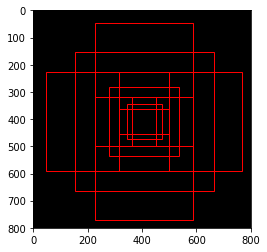

In [6]:
import torch
width = 800
heigth = 800
subsample = 16
image = torch.zeros((1, 3, width, heigth)).float()

w_cntrs = list(range(int(subsample/2), width, subsample))
h_cntrs = list(range(int(subsample/2), heigth, subsample))

import math

def get_anchor(w_, h_, subsample, ratio=(0.5,1,2), size=None):
    if size == None:
        size = (int(subsample/2), subsample, subsample*2)
        
    anchors = []
    for r_ in ratio:
        anchor_ratio = np.array((math.sqrt(r_), math.sqrt(1/r_)))
        for s_ in size:
            anchor_shape = anchor_ratio * s_ * subsample
            x0 = round(w_ - anchor_shape[0]/2)
            x1 = round(w_ + anchor_shape[0]/2)
            y0 = round(h_ - anchor_shape[1]/2)
            y1 = round(h_ + anchor_shape[1]/2)
            
            anchors.append([(x0,y0),(x1,y1)])
    return np.array(anchors)

anchor = get_anchor(w_cntrs[25], h_cntrs[25], subsample)

fig, ax = plt.subplots(1)

ax.imshow(image.squeeze().permute(1,2,0))
draw_boxes(ax, anchor)

In [37]:
# generate anchors
anchors = []
for y in range(int(subsample/2),800,subsample):
    for x in range(int(subsample/2),800,subsample):
        anchor = get_anchor(x,y,subsample)
        anchors.extend(anchor)
anchors = np.array(anchors)

index_inside = np.where(
        (anchors[:,0,0] >= 0) &
        (anchors[:,0,1] >= 0) &
        (anchors[:,1,0] <= 800) &
        (anchors[:,1,1] <= 800)
    )[0]

anchors_inside = anchors[index_inside]

In [39]:
#calculate iou and make labelset

def get_iou(b1, b2):
    a1 = (b1[1][0] - b1[0][0]) * (b1[1][1] - b1[0][1])
    a2 = (b2[1][0] - b2[0][0]) * (b2[1][1] - b2[0][1])
    ai = max(0,(min(b1[1][0], b2[1][0]) - max(b1[0][0], b2[0][0]))) \
    * max(0,(min(b1[1][1], b2[1][1]) - max(b1[0][1], b2[0][1])))
    
    au = a1 + a2 - ai
    return ai/au

def get_locs(gt_, an_):
    height = an_[:,1,0]-an_[:,0,0]
    width = an_[:,1,1]-an_[:,0,1]
    ctr_y = an_[:,0,0] + 0.5 * height
    ctr_x = an_[:,0,1] + 0.5 * width
    
    base_height = gt_[:,1,0] - gt_[:,0,0]
    base_width = gt_[:,1,1] - gt_[:,0,1]
    base_ctr_y = gt_[:,0,0] + 0.5 * base_height
    base_ctr_x = gt_[:,0,1] + 0.5 * base_width
    
    eps = np.finfo(height.dtype).eps
    height = np.maximum(height, eps)
    width = np.maximum(width, eps)
    dy = (base_ctr_y - ctr_y) / height
    dx = (base_ctr_x - ctr_x) / width
    dh = np.log(base_height / height)
    dw = np.log(base_width / width)
    return np.vstack((dy, dx, dh, dw)).transpose()


labels = []
locs = []
for i, target in enumerate(resized_boxes):
    ious = np.zeros((len(target), len(anchors_inside)))
    
    for row, gt in enumerate(target):
        for col, ai in enumerate(anchors_inside):
            ious[row,col] = get_iou(ai,gt)
            
    poss = False
    neus = True
    
    for row in range(ious.shape[0]):
        pos = ious[row]>0.7
        if pos.sum() < 1:
            pos[ious[row].argmax()] = True
        neu = ious[row] < 0.3
        
        poss = poss + pos
        neus = neus * neu
        
    label = -np.ones(len(anchors_inside))
    label[neus] = 0
    label[poss] = 1
    
    final_label = -np.ones(len(anchors))
    final_label[index_inside] = label
    labels.append(final_label)
    
    # if the performance is bad, filter the not intersected ones.
    gt_ = np.array([target[i] for i in ious.argmax(0)])
    
    anchor_locs = get_locs(gt_, anchors_inside)
    
    location = np.empty((len(anchors),4), dtype=anchor_locs.dtype)
    location.fill(0)
    location[index_inside] = anchor_locs
    locs.append(location)
    
    print(i)

labels = np.array(labels)
locs = np.array(locs)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


In [178]:
def print_bbox_and_pos_anchors(index):
    for i,data in enumerate(dataloader):
        if i == index:
            break

    fig, ax = plt.subplots(1)

    ax.imshow(data[0].squeeze().permute(1,2,0))
    draw_boxes(ax, resized_boxes[index])
    draw_boxes(ax, [anchors[i] for i in np.where(labels[index] == 1)[0]], 'y')

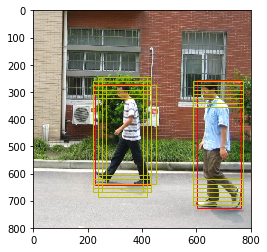

In [180]:
print_bbox_and_pos_anchors(0)

In [709]:
cnn = torchvision.models.vgg16().features[:29]

class RPN(nn.Module):
    def __init__(self, k):
        super(RPN, self).__init__()
        self.k = k
        self.inter = nn.Sequential(
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.ReLU()
        )
        self.cls = nn.Conv2d(512, 18, 1, 1)
        self.reg = nn.Conv2d(512, 36, 1, 1)
        
        self.inter[0].weight.data.normal_(0.01)
        self.inter[0].bias.data.zero_()
        self.cls.weight.data.normal_(0.01)
        self.cls.bias.data.zero_()
        self.reg.weight.data.normal_(0.01)
        self.reg.bias.data.zero_()
        
    def forward(self, x):
        x = self.inter(x)
        return self.cls(x), self.reg(x)

class FasterRCNN(nn.Module):
    def __init__(self, cnn, k):
        super(FasterRCNN, self).__init__()
        self.k = k
        self.cnn = cnn
        self.rpn = RPN(self.k)
    
    def forward(self, x):
        feature_map = self.cnn(x)
        cls, reg = self.rpn(feature_map)
        
        return cls, reg

net = FasterRCNN(cnn, 9)

In [710]:
cls, reg = net(data[0])

In [711]:
pred_anchors = reg.permute(0,2,3,1).contiguous().view(1,-1,4)

pred_cls = cls.permute(0,2,3,1).contiguous()
objective_score = pred_cls.view(1,50,50,9,2).contiguous()[:,:,:,:,1].contiguous().view(1, -1)
pred_cls_score = pred_cls.view(1,-1,2)

In [712]:
anchor_height = anchors[:,1,0] - anchors[:,0,0]
anchor_width = anchors[:,1,1] - anchors[:,0,1]
anchor_y_ctr = anchors[:,0,0] + anchor_height*0.5
anchor_x_ctr = anchors[:,0,1] + anchor_width*0.5

In [713]:
pred_anchors_np = pred_anchors[0].data.numpy()
objective_score_np = objective_score[0].data.numpy()

In [714]:
min_shape = 16
im_size = 800
train_pre_n = 12000
train_post_n = 2000
test_pre_n = 6000
test_post_n = 300

In [715]:
dy = pred_anchors_np[:,0]
dx = pred_anchors_np[:,1]
dh = pred_anchors_np[:,2]
dw = pred_anchors_np[:,3]

In [716]:
ctr_y = dy * anchor_height + anchor_y_ctr
ctr_x = dx * anchor_width + anchor_x_ctr
h = np.exp(dh) * anchor_height
w = np.exp(dw) * anchor_width

In [717]:
roi = np.zeros(pred_anchors_np.shape, dtype=np.float32)
roi[:,0] = np.clip(ctr_y - 0.5*h, 0, im_size)
roi[:,1] = np.clip(ctr_x - 0.5*w, 0, im_size)
roi[:,2] = np.clip(ctr_y + 0.5*h, 0, im_size)
roi[:,3] = np.clip(ctr_x + 0.5*w, 0, im_size)

In [718]:
min_satisfied = np.where((roi[:,2] - roi[:,0] >= min_shape) * (roi[:,3] - roi[:,1] >= min_shape))
roi = roi[min_satisfied]
score = objective_score_np[min_satisfied]

In [719]:
order = score.argsort()[::-1][:train_pre_n]
roi = roi[order]
scores = score[order]

In [720]:
thresh = 0.7

y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
area = (x2 - x1 + 1) * (y2 - y1 + 1)
order = scores.argsort()[::-1]
keep = []

In [721]:
while order.size > 0:
    i = order[0]
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (area[i] + area[order[1:]] - inter)
    inds = np.where(ovr <= thresh)[0]
    order = order[inds + 1]
    keep.append(i)
print(len(keep))
keep = keep[:train_post_n] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals

47


In [722]:
roi

array([[  0.      ,   0.      , 800.      , 800.      ],
       [  0.      ,   0.      , 800.      , 522.1993  ],
       [  0.      , 779.67316 , 800.      , 800.      ],
       [246.4558  ,   0.      , 800.      , 800.      ],
       [  0.      , 362.96094 , 800.      , 800.      ],
       [568.67236 ,   0.      , 800.      , 800.      ],
       [  0.      , 464.10162 , 800.      , 515.01294 ],
       [  0.      ,   0.      , 800.      , 331.99533 ],
       [  0.      , 309.31494 , 800.      , 346.4728  ],
       [732.55774 ,   0.      , 800.      , 800.      ],
       [  0.      , 710.8687  , 800.      , 779.32465 ],
       [  0.      ,   0.      , 800.      ,  57.54335 ],
       [204.94409 ,   0.      , 342.00806 , 800.      ],
       [  0.      ,   0.      , 362.8203  , 800.      ],
       [  0.      , 552.8843  , 800.      , 800.      ],
       [665.96265 ,   0.      , 800.      , 800.      ],
       [  0.      ,   0.      , 800.      , 134.14435 ],
       [  0.      ,   0.      ,

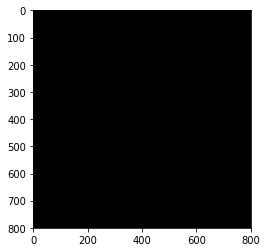

In [723]:
fig, ax = plt.subplots(1)
ax.imshow(image.squeeze().permute(1,2,0))
draw_boxes(ax, roi.reshape(-1,2,2)[:0])

In [724]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [725]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(resized_boxes[0]):
        (yb1, xb1), (yb2, xb2) = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / (anchor_area + box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)

(47, 2)


In [726]:
target[0]

[(16, 92), (280, 783)]

In [727]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 1 1 0 0 0 0]
[0.12117188 0.11483727 0.         0.17512152 0.16257256 0.41904852
 0.09777017 0.03844617 0.07736757 0.13574931 0.0179382  0.
 0.29311046 0.15715066 0.11504899 0.34129474 0.         0.
 0.07638002 0.         0.259929   0.         0.         0.
 0.22743571 0.         0.33194074 0.         0.02984517 0.11534344
 0.06305654 0.         0.05678825 0.07402782 0.11115363 0.1930439
 0.         0.10541531 0.         0.05091818 0.         0.03843974
 0.16250841 0.14844835 0.05620189 0.17163116 0.09230912]


In [728]:
gt_roi_label = gt_assignment

In [729]:
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(n_sample*pos_ratio, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

0
[]


In [730]:
neg_roi_per_this_image

17

In [731]:
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)

47
[ 5  1 44 15 32 43  9 29  3 38 42 36 10 37 34  8 30 18 23 22 16 25 40 39
 11 21  6  2 27 35 26 12 19 41 13 33  7 45 46 28 17 20 14  0 24 31  4]


In [732]:
keep_index = np.append(pos_index, neg_index)
gt_roi_labels = gt_roi_label[keep_index]
gt_roi_labels[pos_roi_per_this_image:] = 0  # negative labels --> 0
sample_roi = roi[keep_index]
print(sample_roi.shape)

(47, 4)


In [733]:
bbox_for_sampled_roi = np.array(resized_boxes[0])[gt_assignment[keep_index]]
print(bbox_for_sampled_roi.shape)
#Out
#(128, 4)
height = sample_roi[:, 2] - sample_roi[:, 0]
width = sample_roi[:, 3] - sample_roi[:, 1]
ctr_y = sample_roi[:, 0] + 0.5 * height
ctr_x = sample_roi[:, 1] + 0.5 * width
base_height = bbox_for_sampled_roi[:, 1,0] - bbox_for_sampled_roi[:, 0,0]
base_width = bbox_for_sampled_roi[:, 1,1] - bbox_for_sampled_roi[:, 0,1]
base_ctr_y = bbox_for_sampled_roi[:, 0,0] + 0.5 * base_height
base_ctr_x = bbox_for_sampled_roi[:, 0,1] + 0.5 * base_width

(47, 2, 2)


In [734]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
gt_roi_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(gt_roi_locs)

[[-3.61470706e-03  1.12500000e-01 -3.37889572e-01 -5.31879033e-01]
 [-8.68750000e-02  3.76102319e-01 -1.37140575e+00 -3.41847214e-01]
 [-8.68750000e-02 -2.43642032e+00 -1.37140575e+00  2.69814200e+00]
 [-3.69160700e-01  1.12500000e-01  2.07826955e-01 -5.31879033e-01]
 [-8.68750000e-02 -4.48426611e+00 -1.37140575e+00  2.68569493e+00]
 [-8.68750000e-02  1.28708317e+00 -1.37140575e+00  1.33380635e+00]
 [-1.22740354e+00  1.12500000e-01  8.94673638e-01 -5.31879033e-01]
 [-8.68750000e-02 -9.94738566e-02 -1.37140575e+00  1.74551897e+00]
 [ 2.89538031e-01  1.12500000e-01 -1.21039611e+00 -5.31879033e-01]
 [-8.68750000e-02  5.47415171e+00 -1.37140575e+00  1.78044401e+00]
 [-6.42675367e-01  1.12500000e-01  1.69587240e+00 -5.31879033e-01]
 [-8.68750000e-02  3.11028026e+00 -1.37140575e+00  1.44493199e+00]
 [ 3.54375000e-01 -3.72643641e+00 -1.57866625e+00  1.92654248e+00]
 [-8.68750000e-02 -2.29092946e+00 -1.37140575e+00  1.67798899e+00]
 [-8.68750000e-02 -1.86545244e+00 -1.37140575e+00  1.80099510e

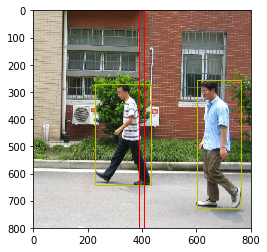

In [682]:
fig, ax = plt.subplots(1)
ax.imshow(data[0].squeeze().permute(1,2,0))
draw_boxes(ax, resized_boxes[0], 'y')
draw_boxes(ax, [roi.reshape(-1,2,2)[14]])